# Import

In [1]:
# Standard Imports
import os
import pandas as pd
import numpy as np
import time
import sys
import gc
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings("ignore")

# Modelling
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
#%pip install lightgbm
import lightgbm as lgb
from sklearn.model_selection import (train_test_split, GridSearchCV)
import statsmodels.api as sm

#basic tools 
import os
import numpy as np
import pandas as pd
import warnings

#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 
#%pip install hgboost
from hgboost import hgboost
from hyperopt import hp
from skopt import gp_minimize

# Visualisation
import plotly.express as px
import plotly.graph_objects as go

# Src modules -- Update the * to get only what I need
sys.path.append(os.path.dirname(os.getcwd())) # Add the parent directory to the Python path so we can import src modules
from src.data_setup import *
from src.decision_tree import *
from src.model_evaluation import model_eval_pipeline,calc_root_mean_squared_error,calc_root_mean_squared_log_error,rmsle_func,rmsle_lgbm
from src.visualisation import *
from src.model_utils import *



# Load Data

In [2]:
# load train,val and test data
#train, test, stores, transactions = get_data()

#data = get_oil_holiday_data()
#df_data=Transform_Data_For_DT(data,60,True)
#df_data_feats=DT_features(df_data,False)
#df_data.to_pickle(DATA_PATH/'processed/DT.pkl')
#df_data_feats.to_pickle(DATA_PATH/'processed/DT_Features.pkl')
#data.to_pickle(DATA_PATH/'processed/Data.pkl')

df_data=pickle.load(open(DATA_PATH/'processed/DT.pkl','rb'))
df_data_feats=pickle.load(open(DATA_PATH/'processed/DT_Features.pkl','rb'))
data=pickle.load(open(DATA_PATH/'processed/Data.pkl','rb'))

# Data Processing

#### Create main dataframes

In [3]:
train = data[data['is_test']==False]
train=train.drop(columns={'is_test'})
test = data[data['is_test']==True]
test=test.drop(columns={'is_test'})

df_data_feats = df_data_feats.astype({'target': 'float'})
df_feats = df_data_feats[df_data_feats['is_test']==False]
df_train = df_data[df_data['is_test']==False]
df_test_feats = df_data_feats[df_data_feats['is_test']==True]
df_test = df_data[df_data['is_test']==True]
df_feats=df_feats.drop(columns={'is_test'})
df_train=df_train.drop(columns={'is_test'})
df_test=df_test.drop(columns={'is_test'})
df_test_feats=df_test_feats.drop(columns={'is_test'})
cat_list=['family','city','state','type']
for x in cat_list:
    list =train[x].unique()
    x_le = pd.DataFrame(list, columns=[x])
    le=LabelEncoder()
    x_le[x+'_le']=le.fit_transform(x_le[x])

####  Create Train and Val

In [4]:
df_train['date']= pd.to_datetime(df_train['date'])
df_feats['date']= pd.to_datetime(df_feats['date'])
try:
    df_train=df_train.drop(columns={'Unnamed: 0'})
except: 
    df_train=df_train
try: 
    df_feats=df_feats.drop(columns={'Unnamed: 0'})
except:
    df_feats=df_feats
#Create the split train/validation
df_training,df_validation=train_val_split(df_train,2)
df_feats_use,df_feats_validation=train_val_split(df_feats,2)

#Remove column for features dataframe
cols = [col for col in df_feats.columns if col not in ['date', 'id', "sales", "day",'target']]
Y_train = df_feats_use['sales']
X_train = df_feats_use[cols]
Y_val = df_feats_validation['sales']
X_val = df_feats_validation[cols]

# Data Exploration

<Figure size 640x480 with 0 Axes>

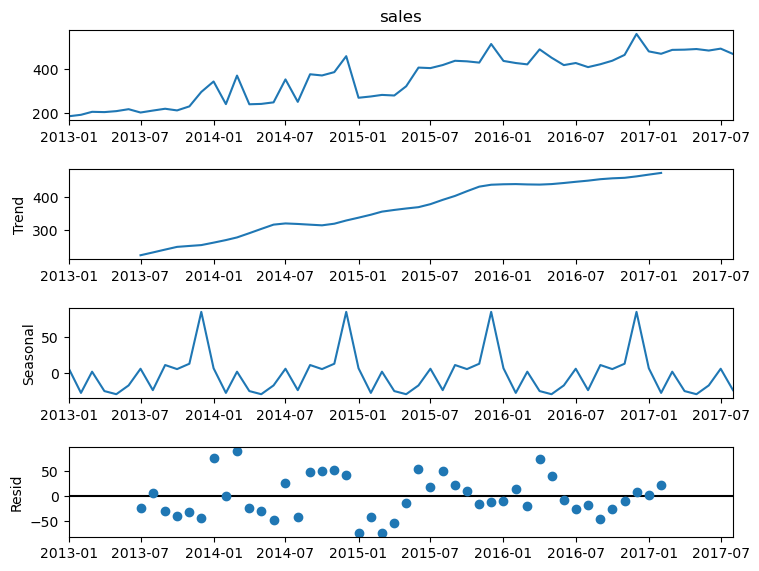

In [5]:
train_plot = train.set_index('date')
y = train_plot['sales'].resample('MS').mean() 

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(8, 6)

In [6]:
generate_interactive_treemap(train,10, [ 'month', 'family','store_nbr'],'sales','sales',3,'Blues')

# Bayes Optimisation - fine tuning hyper parameter

In [7]:
def lgbm_evaluation(params):
    num_leaves, learning_rate, max_depth, feature_fraction, bagging_fraction, bagging_freq, min_data_in_leaf = params
    
    model = lgb.LGBMRegressor(
        boosting_type='gbdt',
        objective='regression',  # Use 'regression' for regression
        metric='None',           # We set metric to 'None' since we'll use our custom evaluation function
        num_leaves=int(num_leaves),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        feature_fraction=feature_fraction,
        bagging_fraction=bagging_fraction,
        bagging_freq=int(bagging_freq),
        min_data_in_leaf=int(min_data_in_leaf),
        verbose=-100
    )

    model.fit(X_train, Y_train, verbose=False)
    y_pred = model.predict(X_val)

    # Calculate the RMSLE score
    rmsle_score = rmsle_func(Y_val, y_pred)

    # Return the RMSLE score
    return rmsle_score

In [8]:
space = [
    (10, 400),  # num_leaves
    (0.01, 0.5),  # learning_rate
    (5, 200),  # max_depth
    (0.1, 0.9),  # feature_fraction
    (0.1, 0.9),  # bagging_fraction
    (0, 100),  # bagging_freq
    (20, 200)  # min_data_in_leaf
]
# Perform Bayesian Optimization to find the best hyperparameters
result = gp_minimize(lgbm_evaluation, space, n_calls=1000, random_state=42)

# Extract the best hyperparameters and their corresponding score
best_params = {
    'num_leaves': int(result.x[0]),
    'learning_rate': result.x[1],
    'max_depth': int(result.x[2]),
    'feature_fraction': result.x[3],
    'bagging_fraction': result.x[4],
    'bagging_freq': int(result.x[5]),
    'min_data_in_leaf': int(result.x[6])
}

best_score = result.fun  # Convert back to positive, as gp_minimize works with the negation of the score

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters:")
print(best_params)
print("Best RMSLE Score:")
print(best_score)

[LightGBM] [Warning] feature_fraction is set=0.5774801263571897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5774801263571897
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_fraction is set=0.456666202282873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.456666202282873
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.14512926322168024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14512926322168024
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.6775990178134599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6775990178134599
[LightGBM] [Warning] bagging_freq is set=9

KeyboardInterrupt: 

# Train Model

#### Train and validate model

In [9]:
# Pick the best parameters from the bayes optimisation to train the model
SEARCH_PARAMS = {'num_leaves': 200, 'learning_rate': 0.5, 'max_depth': 100, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 10, 'min_data_in_leaf': 23}
#SEARCH_PARAMS = best_params
FIXED_PARAMS={'objective': 'regression',
              'metric': 'custom',
              'boosting':'gbdt',
              'min_gain_to_split':0.01,
              'num_boost_round':1000,
              'early_stopping_rounds':100}
param = dict(SEARCH_PARAMS,**FIXED_PARAMS)
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)
model = lgb.train(params=param,
                  train_set=lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=FIXED_PARAMS['num_boost_round'],
                  early_stopping_rounds=FIXED_PARAMS['early_stopping_rounds'],
                  feval=rmsle_lgbm,
                  verbose_eval=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.315573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 2867238, number of used features: 137
[LightGBM] [Info] Start training from score 363.013516
Training until validation scores don't improve for 100 rounds
[50]	training's rmsle: 1.61625	valid_1's rmsle: 1.56259
[100]	training's rmsle: 1.52543	valid_1's rmsle: 1.49749
Early stopping, best iteration is:
[28]	training's rmsle: 1.66572	valid_1's rmsle: 1.38257


In [10]:
#save_model(DECISIONTREE_PATH,model,'lgbm_valid.pkl')

##### Model information

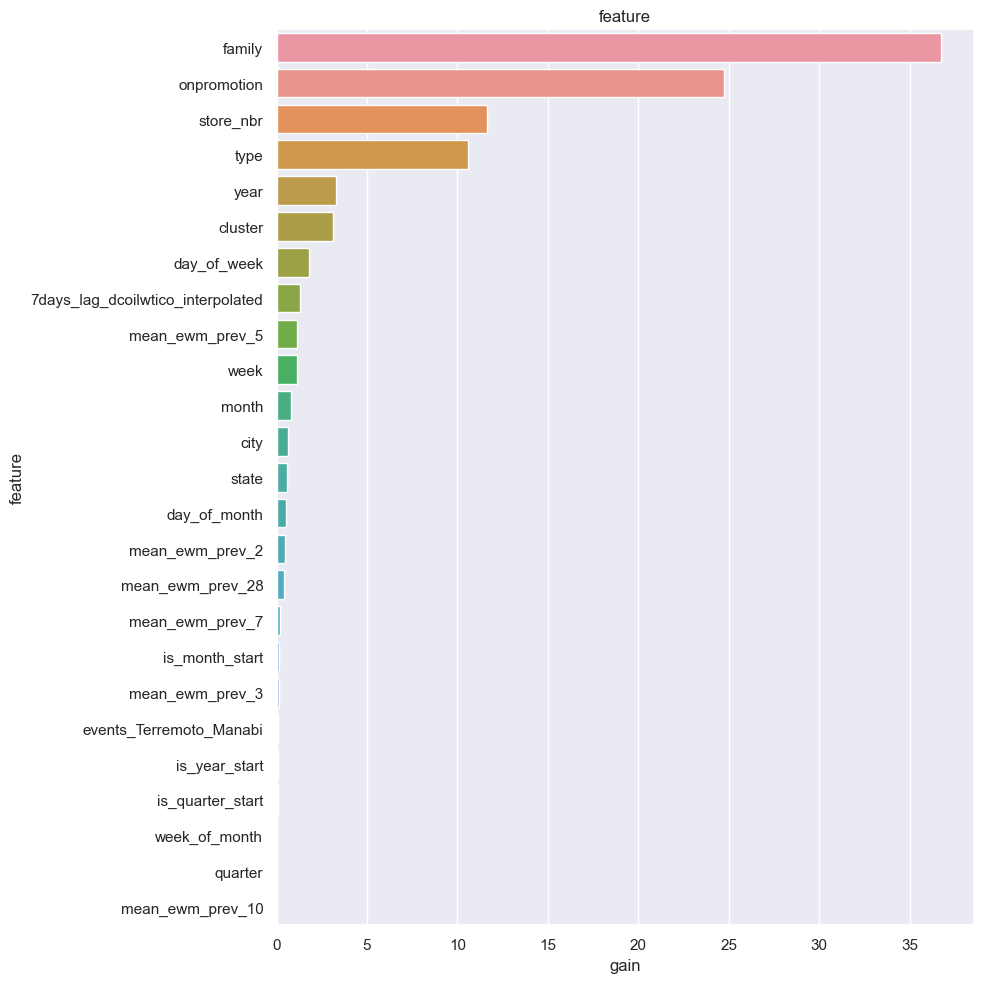

                               feature  split       gain
80                              family    899  36.728018
82                         onpromotion    628  24.749383
81                           store_nbr    946  11.654362
100                               type    316  10.568030
83                                year    241   3.281085
101                            cluster    293   3.128598
87                         day_of_week    354   1.810881
154  7days_lag_dcoilwtico_interpolated    363   1.306120
22                     mean_ewm_prev_5      7   1.146551
85                                week    358   1.113269


In [11]:
plot_lgb_importances(model,30)

### Train model on full train data

In [16]:
Y_train_all = df_feats['sales']
X_train_all = df_feats[cols]
test = test.loc[test.sales.isna()]
X_test = df_test_feats[cols]

# Search Params is already there

FIXED_PARAMS={'objective': 'regression',
              'metric': 'custom',
              'boosting':'gbdt',
              'min_gain_to_split':0.01,
              'num_boost_round':1000}
param = dict(SEARCH_PARAMS,**FIXED_PARAMS)
lgbtrain_all = lgb.Dataset(data=X_train_all, label=Y_train_all, feature_name=cols)
final_model = lgb.train(params=param,
                  train_set=lgbtrain_all,
                  num_boost_round=model.best_iteration,
                  feval=rmsle_lgbm)

#save_model(DECISIONTREE_PATH,final_model,'lgbm_all.pkl')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.235532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1194
[LightGBM] [Info] Number of data points in the train set: 2893968, number of used features: 137
[LightGBM] [Info] Start training from score 363.956847


# Create Submission

##### Prediction

In [17]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration,validate_features =True)

[LightGBM] [Warning] Unknown parameter: validate_features


In [18]:
#Make sure that every prediction is positive and an integer
for i in range(len(test_preds)):
    test_preds[i]=max(0,test_preds[i])
    test_preds[i]=int(test_preds[i])


Output

In [19]:
#Taking only the Test Data
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = test_preds
submission_df['id'] = submission_df.id.astype(int)


#Saving the submission file !!!Update the name of the file!!!
submission_df.to_csv(SUBMISSION_PATH/'submission_lgbm_08.csv', index=False)